# Stock Analysis using Google Search Analytics

Should I buy or sell a specific stock today based off of how popular it is on google searches?

Group 1 <br>
3 August 2021 <br>
BAIS 6040: Data Programming in Python <br>

## Introduction

## Import

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import math
import plotly.express as px
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import random as rnd
from datetime import date
from datetime import timedelta
from pytrends.request import TrendReq
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split    # For generating test/train
from sklearn.linear_model import LinearRegression   # Logistic regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## Global Variables and Initialization

In [2]:
dataDir = r"./Data Files/"  #Directory of all data
today = date.today()  # Todays date
rnd.seed(1024)

## Global Functions

In [3]:
# Function gets stock data and trend data if needed
def get_data(ticker):
    if os.path.exists(f"{dataDir}{ticker}_{today}_year.csv"):
        #Get stored data
        stored_data = pd.read_csv(f"{dataDir}{ticker}_{today}_year.csv")
        # Get rid of index name
        stored_data.set_index('Unnamed: 0', inplace=True)
        stored_data.index.name = None
        return stored_data
    else:
        #Get new data
        # Connect to Google API
        pytrends = TrendReq(hl='en-US', tz=360)
        # Set Keyword
        kw_list = [ticker]
        # Google API only shows last 90 days so need to itirate
        # Set start of interval
        date90front = date.today()
        # Initiate dataframe
        trend_data = pd.DataFrame()
        for x in range(4):
            # Set start end of interval
            date90back = date90front - timedelta(days=90)
            # Build Payload of 90 days
            pytrends.build_payload(kw_list,
                                   timeframe=f'{date90back} {date90front}',
                                   geo='')
            trend_90 = pytrends.interest_over_time()
            trend_data = pd.concat([trend_90, trend_data])
            date90front = date90back
        # Get Stock Data
        stock_data = yf.download(ticker,
                                 start=date.today() - timedelta(days=360),
                                 end=date.today(), interval="1d")
        # Combine Data
        new_data = stock_data.join(trend_data)
        # Create index and add date column
        new_data.reset_index(inplace=True)
        new_data.rename(columns= {"index":"Date"}, inplace = True)
        
        # Rename search interest
        new_data.rename(columns = {ticker: "Search Interest"},inplace = True)
        # Add difference
        new_data["Price Difference"] = new_data["Close"] - new_data["Open"]
        # Add truth value that determines if we want to buy or not that day
        #new_data['Buy'] = np.where(new_data['Price Difference'] > 0, 1, 0)
        # Delete isPartial
        del new_data['isPartial']
        # Delete Date
        del new_data['Date']
        # Remove NaN
        new_data.dropna(inplace=True)  
        # Export to data folder
        new_data.to_csv(f"{dataDir}{ticker}_{today}_year.csv")
        return new_data

# Function prints metrics of regression model
def PrintMetricsRegression(test, predictions):
    print(f"Score: {explained_variance_score(test, predictions):.2f}")
    print(f"MAE: {mean_absolute_error(test, predictions):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(test, predictions)):.2f}")
    print(f"r2: {r2_score(test, predictions):.2f}")

# Function prints metrics of classification model
def PrintMetricsClassiffication(test, predictions):
    print("Confusion Matrix:")
    print(confusion_matrix(test, predictions))
    print("------------------")
    print(f"Accuracy: {accuracy_score(test, predictions):.2f}")
    print(f"Recall: {recall_score(test, predictions):.2f}")
    print(f"Prediction: {precision_score(test, predictions):.2f}")
    print(f"f-measure: {fbeta_score(test, predictions, beta=1):.2f}")
    print("------------------")
    print(classification_report(test, predictions))


# Functions gets random data for predictions
def prepareDataForPredictions(X_df):
    numElements = 3
    amcStockPreparedData = []
    for _ in range(numElements):
        dict = {}
        for column in X.columns:
            min = 0  # assume min = 0
            maxValue = round(max(X_df[column].values))
            dict[column] = rnd.randint(min, maxValue)
        amcStockPreparedData.append(dict)
    return amcStockPreparedData

# Create categorical dummies
def createCategoricalDummies(dataFrame, categoryList):
    return pd.get_dummies(dataFrame[categoryList], prefix_sep = "::", drop_first = True)

## Stock to Analyze

In [4]:
# Gets Data for last year
StockSearch_df = get_data("AMC")
StockSearch_df

,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference
0,3.850000,4.250000,3.840000,4.150000,4.150000,6226600,39.0,0.300000
1,4.070000,4.200000,3.950000,4.160000,4.160000,5489400,41.0,0.090000
2,4.120000,4.340000,4.060000,4.120000,4.120000,3699100,38.0,0.000000
3,4.080000,4.150000,3.950000,4.040000,4.040000,2584900,33.0,-0.040000
4,4.050000,4.200000,3.860000,4.110000,4.110000,4047100,36.0,0.060000
...,...,...,...,...,...,...,...,...
244,32.200001,37.400002,32.139999,36.000000,36.000000,199584500,22.0,3.799999
245,37.830002,38.549999,34.299999,34.959999,34.959999,126277200,24.0,-2.870003
246,32.950001,35.340000,31.150000,34.619999,34.619999,112891300,19.0,1.669998
247,35.139999,44.389999,35.130001,43.090000,43.090000,167634800,21.0,7.950001


## Analytics Model 1 w/ plots

In [5]:
featureColumns=['Search Interest', 'Open']
targetColumn = 'Close'

X=StockSearch_df[featureColumns]
y=StockSearch_df[targetColumn]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Create the regression

In [6]:
lr = LinearRegression()
lr

LinearRegression()

# Fit Linear Model

In [7]:
lr.fit(X_train, y_train)

LinearRegression()

# Our Confidence in our model is high

In [8]:
lr.score(X_train, y_train) 

0.9770443146493532

In [9]:
lr.score(X_test, y_test) 

0.985552486080631

lr.score(X_test, y_test) 

# Print the prediction believed accuracy using the model

In [10]:
predictions = lr.predict(X_test)
PrintMetricsRegression(y_test, predictions)

Score: 0.99
MAE: 1.04
RMSE: 2.15
r2: 0.99


# Create new samples, to test our model

In [11]:
StockSearchPreparedData_df = prepareDataForPredictions(StockSearch_df)
StockSearchPreparedData_df
StockSearch_df

,Open,High,Low,Close,Adj Close,Volume,Search Interest,Price Difference
0,3.850000,4.250000,3.840000,4.150000,4.150000,6226600,39.0,0.300000
1,4.070000,4.200000,3.950000,4.160000,4.160000,5489400,41.0,0.090000
2,4.120000,4.340000,4.060000,4.120000,4.120000,3699100,38.0,0.000000
3,4.080000,4.150000,3.950000,4.040000,4.040000,2584900,33.0,-0.040000
4,4.050000,4.200000,3.860000,4.110000,4.110000,4047100,36.0,0.060000
...,...,...,...,...,...,...,...,...
244,32.200001,37.400002,32.139999,36.000000,36.000000,199584500,22.0,3.799999
245,37.830002,38.549999,34.299999,34.959999,34.959999,126277200,24.0,-2.870003
246,32.950001,35.340000,31.150000,34.619999,34.619999,112891300,19.0,1.669998
247,35.139999,44.389999,35.130001,43.090000,43.090000,167634800,21.0,7.950001


# Prepare the predictions for consumption

In [12]:
StockSearchPrepared_df = pd.DataFrame.from_dict(StockSearchPreparedData_df)
StockSearchPrepared_df

,Search Interest,Open
0,2,30
1,49,20
2,66,6


# Predict what the close price will be

In [13]:
predictions = lr.predict(StockSearchPrepared_df)
predictions

array([29.85626693, 19.98876756,  6.05244282])

# Make it pretty

In [14]:
StockSearchPredicted = StockSearchPrepared_df.copy()
StockSearchPredicted['Price Prediction'] = predictions
StockSearchPredicted

,Search Interest,Open,Price Prediction
0,2,30,29.856267
1,49,20,19.988768
2,66,6,6.052443


## Analytics Model 2 w/ Plots

In [15]:
pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Tesla"] 

pytrends.build_payload(kw_list, timeframe='2021-03-31 2021-07-22', geo='US')

Trendsdf = pytrends.interest_over_time()
Trendsdf = Trendsdf.rename(columns={'Tesla': 'Previous_Search_Interest'})
Trendsdf.shape
Trendsdf

,Previous_Search_Interest,isPartial
date,,
2021-03-31,71,False
2021-04-01,76,False
2021-04-02,71,False
2021-04-03,61,False
2021-04-04,64,False
...,...,...
2021-07-17,59,False
2021-07-18,58,False
2021-07-19,65,False


In [16]:
stockPricePrevious = yf.download("TSLA", start="2021-03-31", end="2021-07-22")
stockPricePrevious = stockPricePrevious.rename(columns={'Open': 'Previous_Open', 'Close': 'Previous_Close','High': 'Previous_High','Volume': 'Previous_Volume','Low': 'Previous_Low', 'Adj Close':'Previous_Adj_Close'})
stockPricePrevious

mergedPriceTrends = pd.concat([stockPricePrevious, Trendsdf], axis=1)
mergedPriceTrends.reset_index(inplace=False, drop=True)
mergedPriceTrends.dropna(inplace=True)

stockPrice = yf.download("TSLA", start="2021-04-01", end="2021-07-23")

mergedPrice = pd.concat([mergedPriceTrends, stockPrice], axis=1)
mergedPrice['Previous_Open'] = mergedPrice['Previous_Open'].shift(1)
mergedPrice['Previous_High'] = mergedPrice['Previous_High'].shift(1)
mergedPrice['Previous_Low'] = mergedPrice['Previous_Low'].shift(1)
mergedPrice['Previous_Close'] = mergedPrice['Previous_Close'].shift(1)
mergedPrice['Previous_Adj_Close'] = mergedPrice['Previous_Adj_Close'].shift(1)
mergedPrice['Previous_Volume'] = mergedPrice['Previous_Volume'].shift(1)
mergedPrice['Previous_Search_Interest'] = mergedPrice['Previous_Search_Interest'].shift(1)
mergedPrice.dropna(inplace=True)

mergedPrice

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Previous_Open,Previous_High,Previous_Low,Previous_Close,Previous_Adj_Close,Previous_Volume,Previous_Search_Interest,isPartial,Open,High,Low,Close,Adj Close,Volume
2021-04-01,646.619995,672.000000,641.109985,667.929993,667.929993,33337300.0,71.0,False,688.369995,692.419983,659.419983,661.750000,661.750000,35298400.0
2021-04-05,688.369995,692.419983,659.419983,661.750000,661.750000,35298400.0,76.0,False,707.710022,708.159973,684.700012,691.049988,691.049988,41842800.0
2021-04-06,707.710022,708.159973,684.700012,691.049988,691.049988,41842800.0,82.0,False,690.299988,696.549988,681.369995,691.619995,691.619995,28271800.0
2021-04-07,690.299988,696.549988,681.369995,691.619995,691.619995,28271800.0,69.0,False,687.000000,691.380005,667.840027,670.969971,670.969971,26309400.0
2021-04-08,687.000000,691.380005,667.840027,670.969971,670.969971,26309400.0,64.0,False,677.380005,689.549988,671.650024,683.799988,683.799988,23924300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15,670.750000,678.609985,652.840027,653.380005,653.380005,21641200.0,57.0,False,658.390015,666.140015,637.880005,650.599976,650.599976,20209600.0
2021-07-16,658.390015,666.140015,637.880005,650.599976,650.599976,20209600.0,59.0,False,654.679993,656.700012,642.200012,644.219971,644.219971,16339800.0
2021-07-19,654.679993,656.700012,642.200012,644.219971,644.219971,16339800.0,62.0,False,629.890015,647.200012,621.289978,646.219971,646.219971,21297100.0
2021-07-20,629.890015,647.200012,621.289978,646.219971,646.219971,21297100.0,65.0,False,651.989990,662.390015,640.500000,660.500000,660.500000,15442700.0


In [17]:
columns = ["Previous_Open", "Previous_High", "Previous_Low", "Previous_Close", "Previous_Volume", "Previous_Search_Interest", "Close"]
mergedPrice = mergedPrice[columns]
mergedPrice

,Previous_Open,Previous_High,Previous_Low,Previous_Close,Previous_Volume,Previous_Search_Interest,Close
2021-04-01,646.619995,672.000000,641.109985,667.929993,33337300.0,71.0,661.750000
2021-04-05,688.369995,692.419983,659.419983,661.750000,35298400.0,76.0,691.049988
2021-04-06,707.710022,708.159973,684.700012,691.049988,41842800.0,82.0,691.619995
2021-04-07,690.299988,696.549988,681.369995,691.619995,28271800.0,69.0,670.969971
2021-04-08,687.000000,691.380005,667.840027,670.969971,26309400.0,64.0,683.799988
...,...,...,...,...,...,...,...
2021-07-15,670.750000,678.609985,652.840027,653.380005,21641200.0,57.0,650.599976
2021-07-16,658.390015,666.140015,637.880005,650.599976,20209600.0,59.0,644.219971
2021-07-19,654.679993,656.700012,642.200012,644.219971,16339800.0,62.0,646.219971
2021-07-20,629.890015,647.200012,621.289978,646.219971,21297100.0,65.0,660.500000


In [18]:
features = list(mergedPrice.columns)
features.remove("Close")
target = "Close"

X = mergedPrice[features]
y = mergedPrice[target]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, shuffle=False)

In [20]:
lr = LinearRegression()
lr

LinearRegression()

In [21]:
lr.fit(X_train, y_train)

LinearRegression()

In [22]:
lr.score(X_train, y_train)

0.889909218635416

In [23]:
lr.score(X_test, y_test)

0.12337453509099794

In [24]:
def printMetrics(test, predictions):
    print(f"Score: {explained_variance_score(test, predictions):.2f}")
    print(f"MAE: {mean_absolute_error(test, predictions):.2f}")
    print(f"RMSE: {math.sqrt(mean_squared_error(test, predictions)):.2f}")
    print(f"r2: {r2_score(test, predictions):.2f}")

predictions = lr.predict(X_test)
printMetrics(y_test, predictions)

Score: 0.13
MAE: 9.64
RMSE: 12.00
r2: 0.12


In [25]:
predictions = lr.predict(X_test)
printMetrics(y_test, predictions)

Score: 0.13
MAE: 9.64
RMSE: 12.00
r2: 0.12


In [26]:
predictions = lr.predict(X_test)
predictions

array([673.79559711, 680.00122858, 670.54413485, 664.14880799,
       650.60849818, 645.31137095, 660.18236253, 677.80445862,
       668.38164841, 654.36527996, 653.06372076, 647.87733808,
       643.81760185, 660.00565154])

In [27]:
X_test = X_test.copy()
X_test['Predicted_Close'] = predictions
X_test

,Previous_Open,Previous_High,Previous_Low,Previous_Close,Previous_Volume,Previous_Search_Interest,Predicted_Close
2021-07-01,679.770020,692.809998,678.140015,679.700012,18924900.0,64.0,673.795597
2021-07-02,683.919983,687.989990,672.799988,677.919983,18634500.0,63.0,680.001229
2021-07-06,678.979980,700.000000,673.260010,678.900024,27054500.0,64.0,670.544135
2021-07-07,681.710022,684.000000,651.400024,659.580017,23284500.0,64.0,664.148808
2021-07-08,664.270020,665.700012,638.320007,644.650024,18792000.0,57.0,650.608498
2021-07-09,628.369995,654.429993,620.460022,652.809998,22773300.0,63.0,645.311371
2021-07-12,653.179993,658.909973,644.690002,656.950012,18118500.0,64.0,660.182363
2021-07-13,662.200012,687.239990,662.159973,685.700012,25927000.0,65.0,677.804459
2021-07-14,686.320007,693.280029,666.299988,668.539978,20966100.0,60.0,668.381648
2021-07-15,670.750000,678.609985,652.840027,653.380005,21641200.0,57.0,654.365280


In [28]:
stockPrice = stockPrice.rename(columns={'Close': 'Actual_Close'})
predictedPrice = pd.concat([stockPrice, X_test], axis=1)
predictedPrice.dropna(inplace=True)
predictedPrice

,Open,High,Low,Actual_Close,Adj Close,Volume,Previous_Open,Previous_High,Previous_Low,Previous_Close,Previous_Volume,Previous_Search_Interest,Predicted_Close
2021-07-01,683.919983,687.989990,672.799988,677.919983,677.919983,18634500,679.770020,692.809998,678.140015,679.700012,18924900.0,64.0,673.795597
2021-07-02,678.979980,700.000000,673.260010,678.900024,678.900024,27054500,683.919983,687.989990,672.799988,677.919983,18634500.0,63.0,680.001229
2021-07-06,681.710022,684.000000,651.400024,659.580017,659.580017,23284500,678.979980,700.000000,673.260010,678.900024,27054500.0,64.0,670.544135
2021-07-07,664.270020,665.700012,638.320007,644.650024,644.650024,18792000,681.710022,684.000000,651.400024,659.580017,23284500.0,64.0,664.148808
2021-07-08,628.369995,654.429993,620.460022,652.809998,652.809998,22773300,664.270020,665.700012,638.320007,644.650024,18792000.0,57.0,650.608498
2021-07-09,653.179993,658.909973,644.690002,656.950012,656.950012,18118500,628.369995,654.429993,620.460022,652.809998,22773300.0,63.0,645.311371
2021-07-12,662.200012,687.239990,662.159973,685.700012,685.700012,25927000,653.179993,658.909973,644.690002,656.950012,18118500.0,64.0,660.182363
2021-07-13,686.320007,693.280029,666.299988,668.539978,668.539978,20966100,662.200012,687.239990,662.159973,685.700012,25927000.0,65.0,677.804459
2021-07-14,670.750000,678.609985,652.840027,653.380005,653.380005,21641200,686.320007,693.280029,666.299988,668.539978,20966100.0,60.0,668.381648
2021-07-15,658.390015,666.140015,637.880005,650.599976,650.599976,20209600,670.750000,678.609985,652.840027,653.380005,21641200.0,57.0,654.365280


Text(0.5, 1.0, 'Predicted Close Price vs. Actual Close Price')

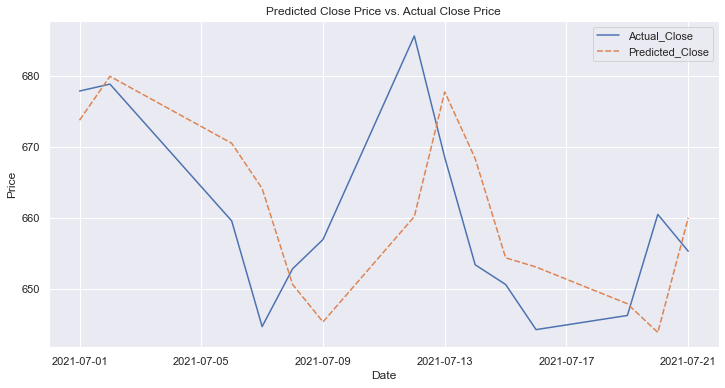

In [29]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(data=predictedPrice[["Actual_Close","Predicted_Close"]], ax=ax)
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Predicted Close Price vs. Actual Close Price")


## Conclusion

You shoud {buy/sell} with this {##%} confidence